In [1]:
import glob
import cv2
import numpy as np
import ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [2]:
# ! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

# Load Models

In [2]:
seg_model = YOLO('./resources/id_seg_best.pt')
rot_model = YOLO('./resources/rot_cls_best.pt')
front_lines_model = YOLO('./resources/front_line_det_best.pt')
back_lines_model = YOLO('./resources/back_line_det_best.pt')

# Helper functions

In [3]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")

	s = pts.sum(axis = 1)

	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect


def adjust_perspective(image, pts):

    rect = order_points(pts)

    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

def correct_rotation(image, rot_model, class_names):
    """
    Classifies an image and corrects its rotation if needed.
    """
    pred = rot_model(image, verbose=False)
    top1_index = pred[0].probs.top1
    class_name = class_names[top1_index]

    if class_name in ['1_180_front', '3_180_back']:
        return cv2.rotate(image, cv2.ROTATE_180)
    else:
        return image

# Main Function

In [4]:
def extract_lines(id_image, visualise=True):

  # ID Segmentation
  pred = seg_model(id_image, verbose=False)
  pred = pred[0].masks.xy[0]

  # Cropp ID and adjust perspective
  corrected = adjust_perspective(id_image, pred)

  # Correct rotation if needed
  if corrected.shape[0]>corrected.shape[1]:
    corrected=cv2.rotate(corrected, cv2.ROTATE_90_CLOCKWISE)

  corrected_rotation_img = correct_rotation(corrected, rot_model, rot_model.names)
  rot_pred = rot_model(corrected_rotation_img, verbose=False)
  top1_index = rot_pred[0].probs.top1
  class_name = rot_model.names[top1_index]

  # Detect lines
  if class_name in ["0_correct_front",'1_180_front']:
    lines_pred = front_lines_model(corrected_rotation_img, verbose=False)
  else:
    lines_pred = back_lines_model(corrected_rotation_img, verbose=False)

  # Extract lines
  extracted_lines_dict = {}
  if lines_pred[0].boxes is not None:
    for box in lines_pred[0].boxes:
        x1, y1, x2, y2 = [int(i) for i in box.xyxy[0]]
        cropped_line = corrected_rotation_img[y1:y2, x1:x2]
        line_class = lines_pred[0].names[int(box.cls[0])]
        if line_class not in extracted_lines_dict:
            extracted_lines_dict[line_class] = []
        extracted_lines_dict[line_class].append(cropped_line)


  if visualise:
    img_with_predictions = lines_pred[0].plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(img_with_predictions)
    plt.axis('off')
    plt.show()

  return extracted_lines_dict

# Test Case

In [5]:
front_cases = [cv2.imread(i) for i in glob.glob("./test_cases/front*")]
back_cases = [cv2.imread(i) for i in glob.glob("./test_cases/back*")]
len(back_cases), len(front_cases)

(2, 2)

### Two Front cases

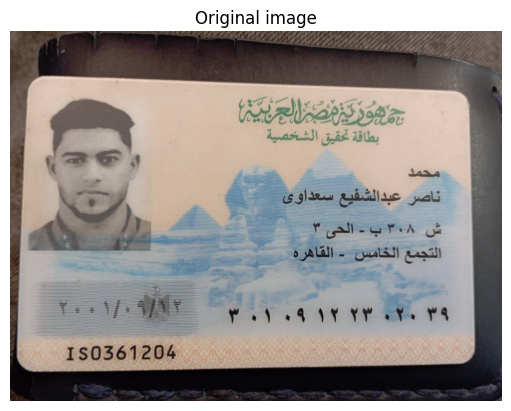

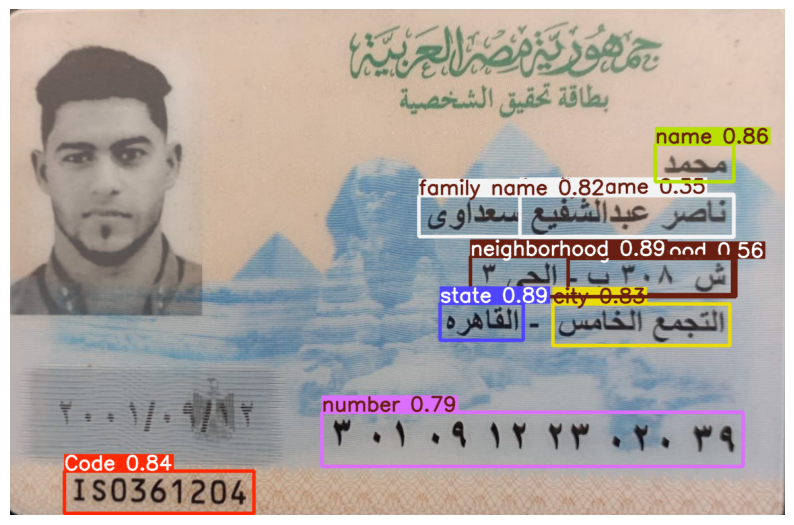

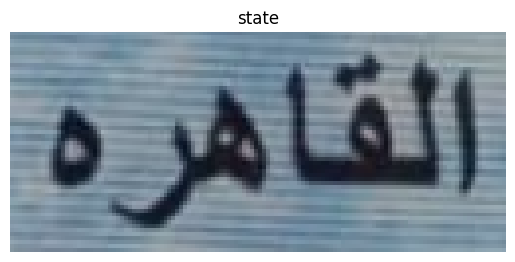

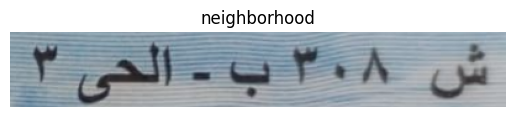

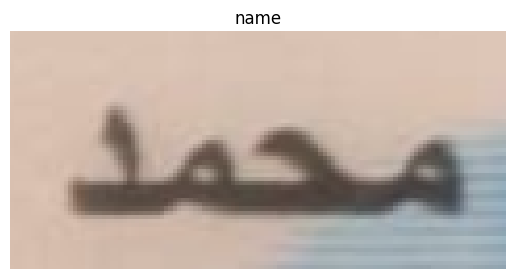

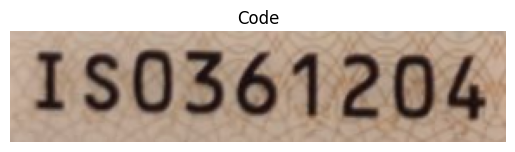

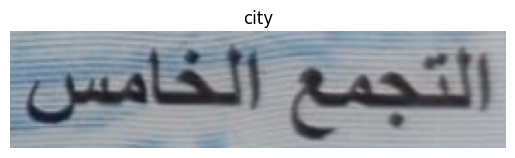

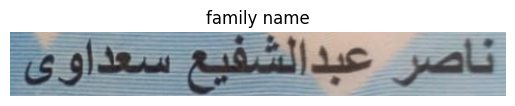

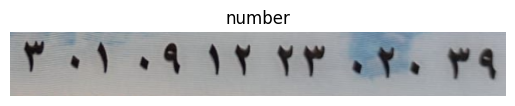

In [6]:
ndx = 0
plt.imshow(front_cases[ndx])
plt.title("Original image")
plt.axis('off')
plt.show()

extracted_lines = extract_lines(front_cases[ndx], visualise=True)
for key in extracted_lines.keys():

  plt.title(key)
  plt.imshow(extracted_lines[key][0])
  plt.axis('off') # Hide axes
  plt.show()

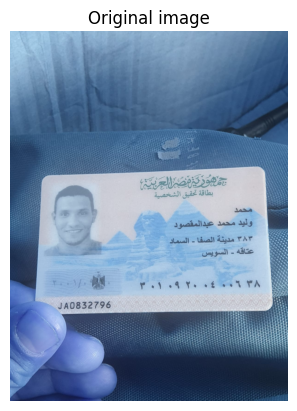

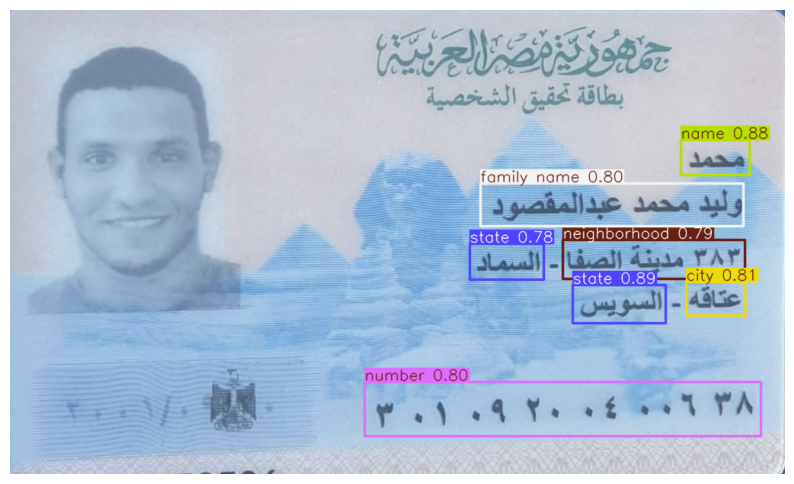

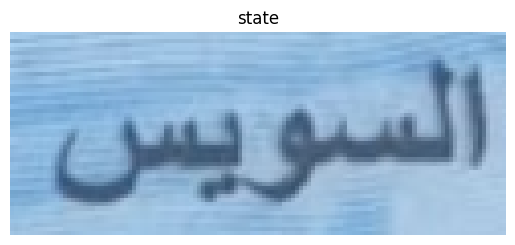

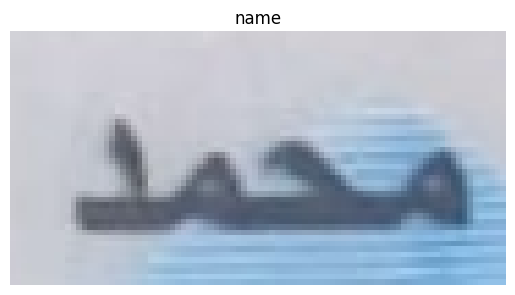

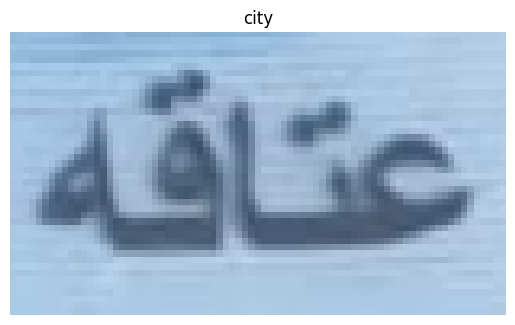

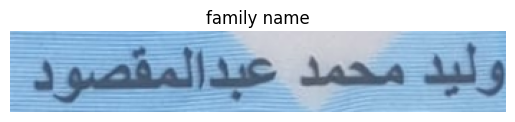

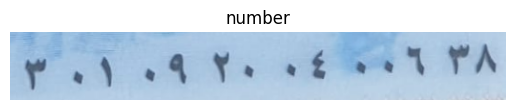

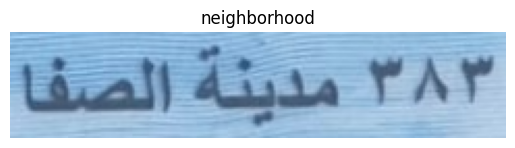

In [7]:
ndx = 1
plt.imshow(front_cases[ndx])
plt.title("Original image")
plt.axis('off')
plt.show()

extracted_lines = extract_lines(front_cases[ndx], visualise=True)
for key in extracted_lines.keys():

  plt.title(key)
  plt.imshow(extracted_lines[key][0])
  plt.axis('off') # Hide axes
  plt.show()

### Two back cases

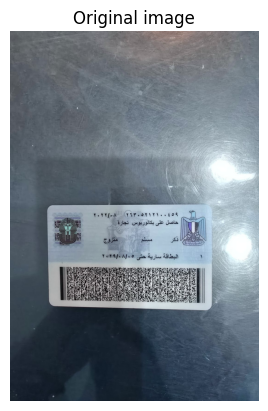

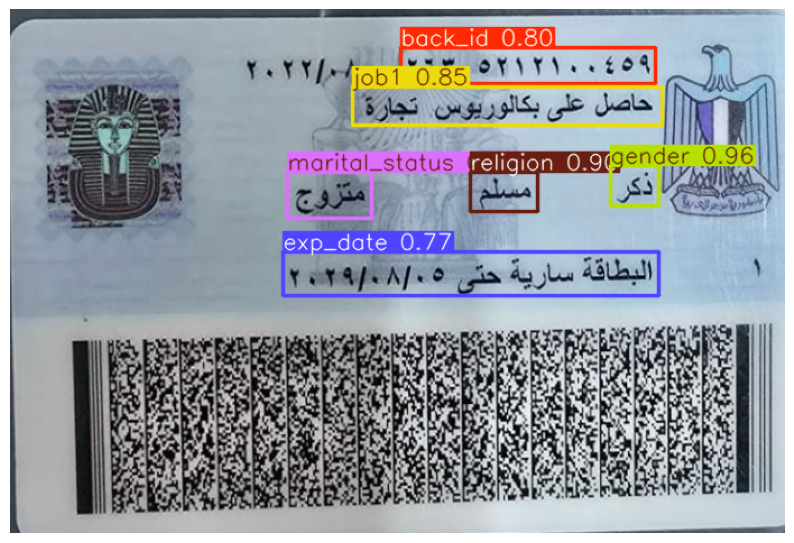

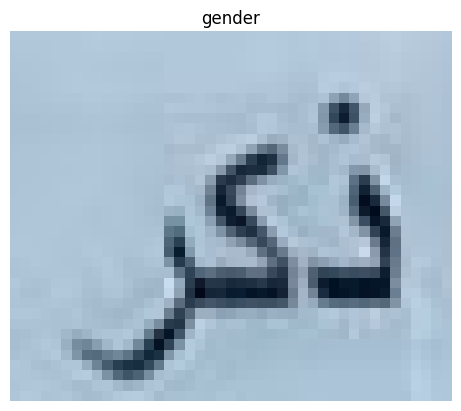

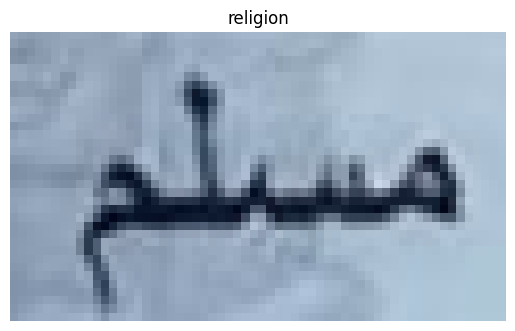

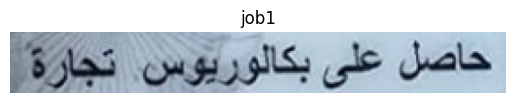

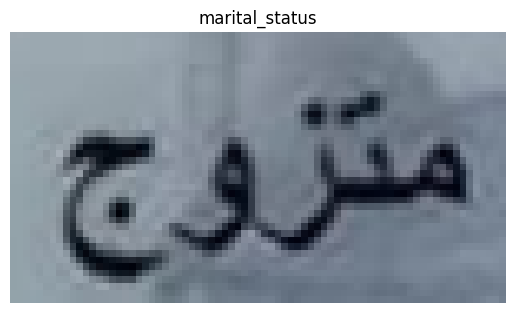

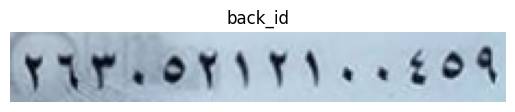

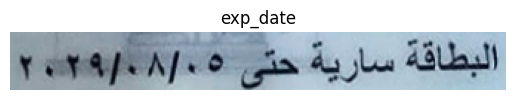

In [8]:
ndx = 0
plt.imshow(back_cases[ndx])
plt.title("Original image")
plt.axis('off')
plt.show()

extracted_lines = extract_lines(back_cases[ndx], visualise=True)
for key in extracted_lines.keys():

  plt.title(key)
  plt.imshow(extracted_lines[key][0])
  plt.axis('off') 
  plt.show()

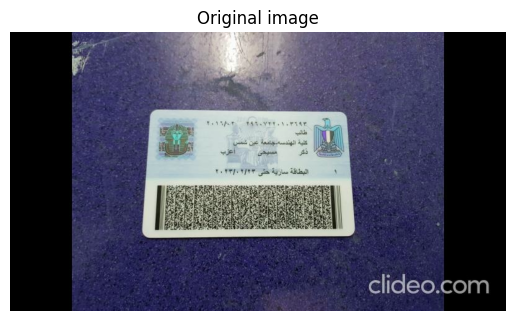

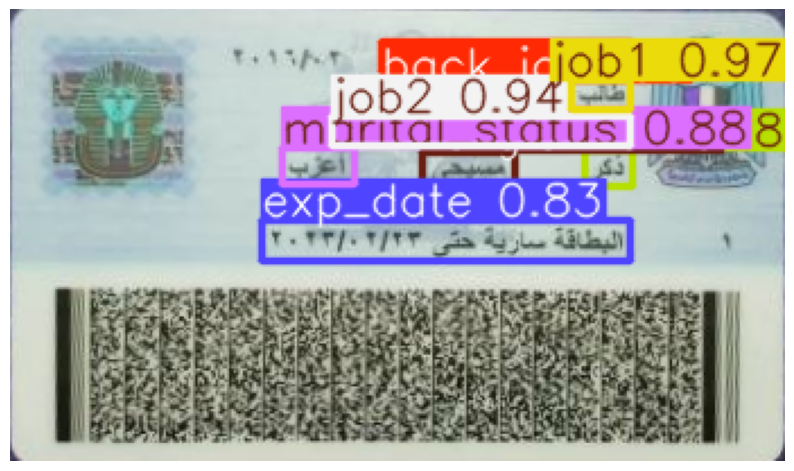

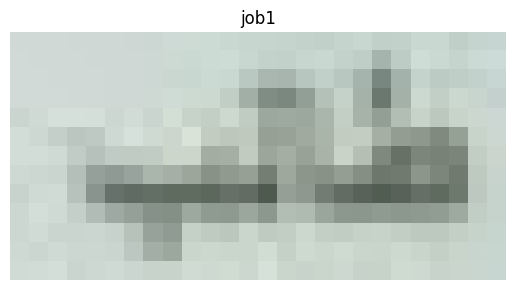

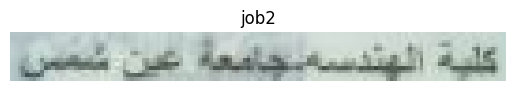

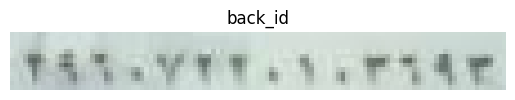

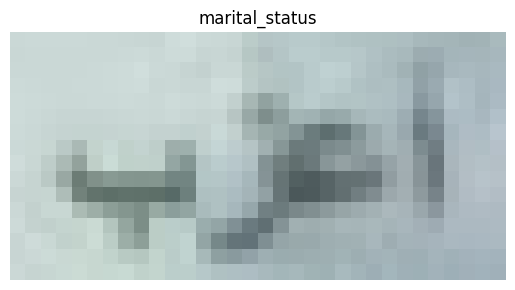

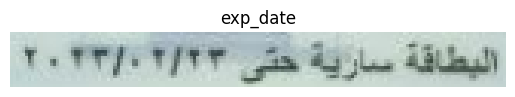

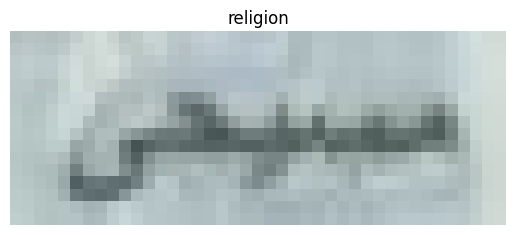

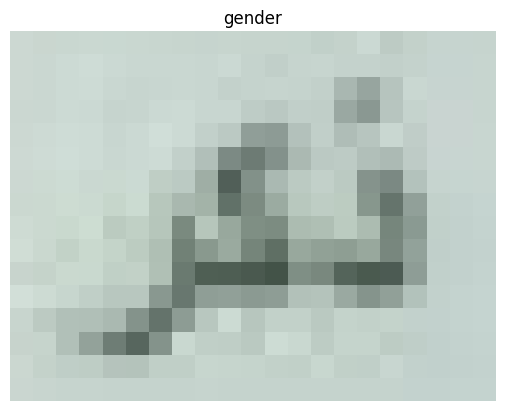

In [9]:
ndx = 1
plt.imshow(back_cases[ndx])
plt.title("Original image")
plt.axis('off')
plt.show()

extracted_lines = extract_lines(back_cases[ndx], visualise=True)
for key in extracted_lines.keys():

  plt.title(key)
  plt.imshow(extracted_lines[key][0])
  plt.axis('off') 
  plt.show()